## Looking at Individual Payer 417614
### v3.0 (final)

This notebook is Luke Corwin's investigation of several different models on one payer. We concluded that treating all payers together gave higher performance than modeling them separately.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
#We were given several different data sets, and I merged them together for this investigation.
bridge = pd.read_csv("../data/bridge.csv")
dim_claims = pd.read_csv("../data/dim_claims.csv")
dim_date = pd.read_csv("../data/dim_date.csv")
dim_pa = pd.read_csv("../data/dim_pa.csv")

In [3]:
df2 = bridge.merge(dim_claims, on='dim_claim_id', how='left').copy()
df4 = df2.merge(dim_pa, on='dim_pa_id', how='left').copy()

In [4]:
#Select only those rows in the merged data set that contain this payer
mypayer=df4[df4.bin == 417614].copy()

In [5]:
#Impute -1 into all of the N/A values
mypayer = mypayer.fillna(-1)

Do we have any cases where the drug is rejected, but a PA is not requested? If we do, the code below will retrun -1

In [6]:
min(mypayer[(mypayer.pharmacy_claim_approved == 0)].dim_pa_id)

5.0

Now, to tackle the question "If a PA is required which features on the PA claim (Correct diagnosis, Tried and failed, Contraindication) help get the PA approved?"

Given what we found above, all or nearly all of the code 75 rejections should be approved with a PA

We also perform a train/test split.

In [7]:
pa = mypayer[mypayer.pharmacy_claim_approved == 0].copy()
y = pa['pa_approved']

X_train,X_test,y_train,y_test = train_test_split(pa,y,
                                                 test_size = .25,
                                                 random_state = 614,
                                                 shuffle = True,
                                                 stratify = y)

codes = X_train['reject_code'].unique()

for code in codes:
    if(code != -1): 
        pa_approved = X_train[(X_train.reject_code == code) & (y_train == 1)].shape[0]
        pa_req = X_train[(X_train.reject_code == code) & (X_train.dim_pa_id > 0)].shape[0]
        if(pa_req == 0): 
            app_rate = -99
        else:
            app_rate = pa_approved/pa_req
        print("Reject Code ",code,"has approval rate of ",app_rate)

Reject Code  70.0 has approval rate of  0.5817332685637341
Reject Code  75.0 has approval rate of  0.973280051475693
Reject Code  76.0 has approval rate of  0.6401508011310085


## Baselining 

What metrics would we measure if we assumed all PAs would be accepted and merged all payers together? This would be the "least intelligent" way to do it, so any machine learning method should be better.

In [8]:
rejected = df4[(df4.pa_approved == 0)].shape[0]
accepted = df4[(df4.pa_approved == 1)].shape[0]

tp = accepted
fp = rejected
fn = tn = 0

a = (tp+tn)/(tp+fp+fn+tn)
p = (tp)/(tp+fp)
r = tp/(tp+fn)
f1 = 2*(p*r)/(p+r)

print("Accuracy is ",np.round(a,5))
print("Precision is ",np.round(p,5))
print("Recall is ",np.round(r,5))
print("F1 is ",np.round(f1,5))

Accuracy is  0.73445
Precision is  0.73445
Recall is  1.0
F1 is  0.8469


## Now, using actual data science methods

First we one-hot encode the rejection code and the drug

In [9]:

rcd = pd.get_dummies(X_train['reject_code'])
#hot code the rejection codes

X_train.loc[:,'not_in_formulary'] = pd.get_dummies(X_train['reject_code'])[70.0]
X_train.loc[:,'limit_exceeded'] = pd.get_dummies(X_train['reject_code'])[76.0]            

/home/luke/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/luke/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [10]:
#hot code the drugs

X_train.loc[:,'Drug A']=pd.get_dummies(X_train['drug'])['A']
X_train.loc[:,'Drug B']=pd.get_dummies(X_train['drug'])['B']

### Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
#We keep only the features on which we want to regress.

features = ['correct_diagnosis','tried_and_failed','contraindication',
           'not_in_formulary','limit_exceeded','Drug A','Drug B']
X_train = X_train[features] 


We measure our performance using several metrics (mainly recall and precision)

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# import cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier

In all cases we use 10-fold cross-validation

In [14]:
f = 10
kfold = StratifiedKFold(f,shuffle=True,random_state=440)

In [15]:
cutoffs = np.arange(0.0,1.0,0.02)

accs = np.zeros((f,len(cutoffs)))
precs = np.zeros((f,len(cutoffs)))
recs = np.zeros((f,len(cutoffs)))
f1s = np.zeros((f,len(cutoffs)))

log_reg = LogisticRegression()
tree_clf = DecisionTreeClassifier(random_state = 440)

z=0

fold = 0

for train_index,test_index in kfold.split(X_train,y_train):
    y_train_train,y_train_test = y_train.iloc[train_index],y_train.iloc[test_index]
    X_train_train =X_train.iloc[train_index]
    X_train_test = X_train.iloc[test_index]
    print("Now training fold",fold+1,"of",f)
    log_reg_clone = clone(log_reg)
    log_reg_clone.fit(X_train_train,y_train_train)
    probs = log_reg_clone.predict_proba(X_train_test)[:,1]
    #Our hyper-parameter is the cutoff probability where we classify whether this ePA will be approved or not
    for j in range(len(cutoffs)):     
        y_pred = 1*(probs > cutoffs[j])
        accs[fold,j] = accuracy_score(y_train_test,y_pred)
        precs[fold,j] = precision_score(y_train_test,y_pred,zero_division=z)
        recs[fold,j] = recall_score(y_train_test,y_pred,zero_division=z)
        f1s[fold,j] = f1_score(y_train_test,y_pred,zero_division=z)
    fold=fold+1

print("Training Done!")

Now training fold 1 of 10
Now training fold 2 of 10
Now training fold 3 of 10
Now training fold 4 of 10
Now training fold 5 of 10
Now training fold 6 of 10
Now training fold 7 of 10
Now training fold 8 of 10
Now training fold 9 of 10
Now training fold 10 of 10
Training Done!


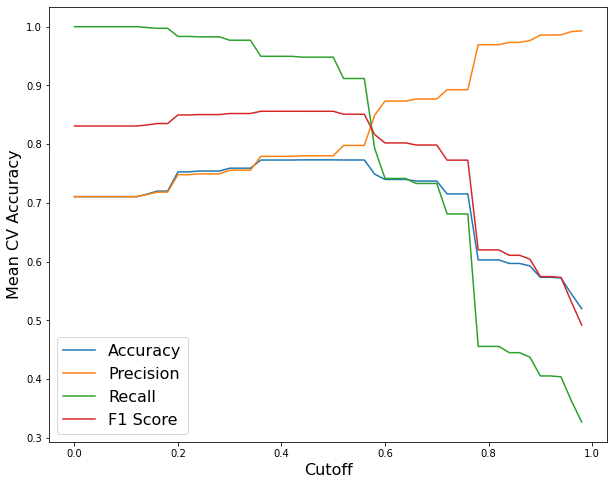

Our optimal cutoff at 0.58 gives is a recall of  0.7929 with a precision of 0.8494


In [17]:
plt.figure(figsize=(10,8))

plt.plot(cutoffs,np.mean(accs,axis=0),label="Accuracy")
plt.plot(cutoffs,np.mean(precs,axis=0),label="Precision")
plt.plot(cutoffs,np.mean(recs,axis=0),label="Recall")
plt.plot(cutoffs,np.mean(f1s,axis=0),label="F1 Score")


plt.xlabel("Cutoff", fontsize=16)
plt.ylabel("Mean CV Score", fontsize=16)

plt.legend(fontsize=16)


plt.xlabel("Cutoff", fontsize=16)
plt.ylabel("Mean CV Accuracy", fontsize=16)
plt.savefig("BasicLogReg.jpg")
plt.show()

prec_guard = 0.8
prec = np.mean(precs,axis=0)
rec = np.mean(recs,axis=0)

prec2 = prec[prec>prec_guard]
rec2 = rec[prec>prec_guard]

#Find Highest recall with precision greater than guardrail value (0.8)
l = np.argmax(rec2)
cot = cutoffs[prec>prec_guard]

print("Our optimal cutoff at",np.round(cot[l],4),"gives is a recall of ",np.round(rec2[l],4),
      "with a precision of",np.round(prec2[l],4))


Let's see if we can determine how the features affect the outcome.

In [18]:
log_reg_T = LogisticRegression()
log_reg_T.fit(X_train,y_train)

LogisticRegression()

In [19]:
betas = log_reg_T.coef_
betas.shape

for i in range(0,betas.shape[1]):
    print("Changing ",X_train.iloc[:,i].name," from 0 to 1 multiplies the odds of being accepted by "+
          str(np.round(np.exp(1*log_reg_T.coef_[0][i]),2)))



Changing  correct_diagnosis  from 0 to 1 multiplies the odds of being accepted by 1.36
Changing  tried_and_failed  from 0 to 1 multiplies the odds of being accepted by 2.49
Changing  contraindication  from 0 to 1 multiplies the odds of being accepted by 0.16
Changing  not_in_formulary  from 0 to 1 multiplies the odds of being accepted by 0.57
Changing  limit_exceeded  from 0 to 1 multiplies the odds of being accepted by 0.44
Changing  Drug A  from 0 to 1 multiplies the odds of being accepted by 0.57
Changing  Drug B  from 0 to 1 multiplies the odds of being accepted by 12.53


### Decision Tree

In [21]:
#Try a decision tree, with a max depth of up to 10
m = 10
maxdepth = range(1,m+1)

accs = np.zeros((f,len(maxdepth)))
precs = np.zeros((f,len(maxdepth)))
recs = np.zeros((f,len(maxdepth)))
f1s = np.zeros((f,len(maxdepth)))


z=0

fold = 0

for train_index,test_index in kfold.split(X_train,y_train):
    #print(train_index)
    #print(test_index)
    y_train_train,y_train_test = y_train.iloc[train_index],y_train.iloc[test_index]
    X_train_train =X_train.iloc[train_index]
    X_train_test = X_train.iloc[test_index]
    print("Now training fold",fold+1,"of",f)

    for j in range(1,m):
        tree = DecisionTreeClassifier(max_depth=j, random_state = 440)
        fig = tree.fit(X_train_train,y_train_train)
        
        y_pred = tree.predict(X_train_test)
        accs[fold,j] = accuracy_score(y_train_test,y_pred)
        precs[fold,j] = precision_score(y_train_test,y_pred,zero_division=z)
        recs[fold,j] = recall_score(y_train_test,y_pred,zero_division=z)
        f1s[fold,j] = f1_score(y_train_test,y_pred,zero_division=z)
    fold=fold+1

Now training fold 1 of 10
Now training fold 2 of 10
Now training fold 3 of 10
Now training fold 4 of 10
Now training fold 5 of 10
Now training fold 6 of 10
Now training fold 7 of 10
Now training fold 8 of 10
Now training fold 9 of 10
Now training fold 10 of 10


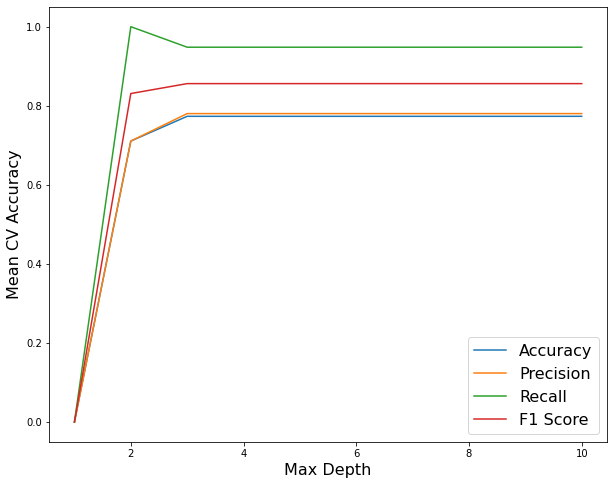

In [23]:
plt.figure(figsize=(10,8))

plt.plot(maxdepth,np.mean(accs,axis=0),label="Accuracy")
plt.plot(maxdepth,np.mean(precs,axis=0),label="Precision")
plt.plot(maxdepth,np.mean(recs,axis=0),label="Recall")
plt.plot(maxdepth,np.mean(f1s,axis=0),label="F1 Score")


plt.xlabel("Max Depth", fontsize=16)
plt.ylabel("Mean CV Score", fontsize=16)

plt.legend(fontsize=16)


plt.xlabel("Max Depth", fontsize=16)
plt.ylabel("Mean CV Accuracy", fontsize=16)
plt.savefig("BasicDecTree.jpg")
plt.show()


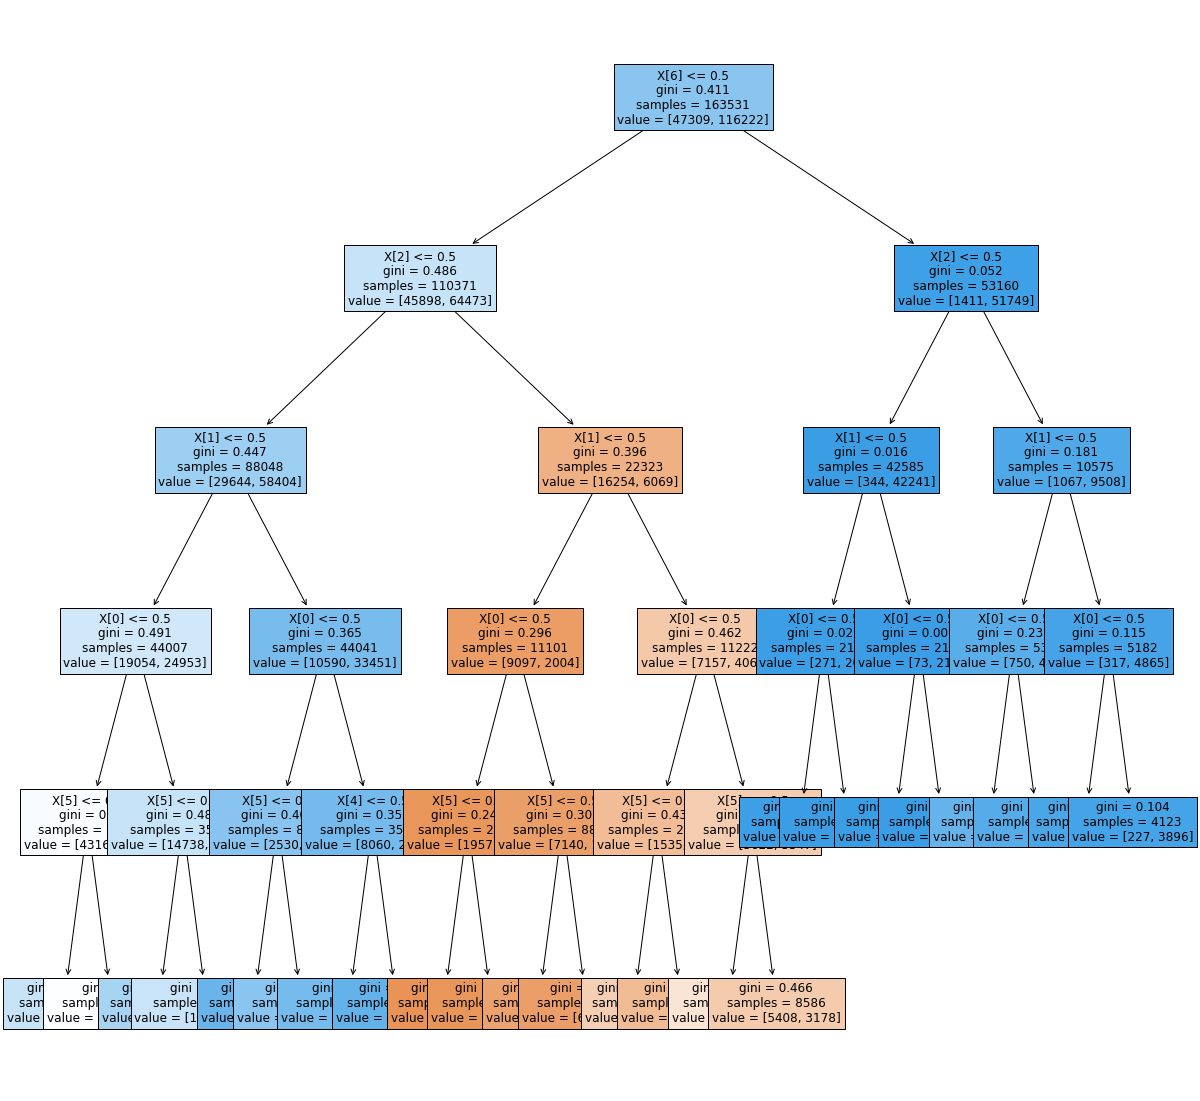

In [24]:
plt.figure(figsize = (20,20))


from sklearn import tree as t

t.plot_tree(fig,filled = True,fontsize=12)
plt.show()

### Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
depth_limit = 20

CV_acc = np.empty((f,depth_limit))
prec = np.empty((f,depth_limit))
recall = np.empty((f,depth_limit))


## Perform kfold cross validation here for max depth or 
## min_samples_split here
fold =0

for train_index, test_index in kfold.split(X_train,y_train):
    X_train_train,X_train_test = X_train.iloc[train_index],X_train.iloc[test_index]
    y_train_train,y_train_test = y_train.iloc[train_index],y_train.iloc[test_index]
    print("Now training fold",fold+1,"of",f)
    for md in range(1,depth_limit+1):
        dec_tree = RandomForestClassifier(max_depth=md,random_state=440)
        dec_tree.fit(X_train_train,y_train_train)
        y_pred = dec_tree.predict(X_train_test)
        CV_acc[fold,md-1] = accuracy_score(y_train_test,y_pred)
        prec[fold,md-1] = precision_score(y_train_test,y_pred)
        recall[fold,md-1] = recall_score(y_train_test,y_pred)
    fold=fold+1
    
print("Training Done!")


Now training fold 1 of 10


In [ ]:
plt.figure(figsize=(10,8))

xd = range(1,depth_limit+1)

plt.plot(xd,np.mean(prec,axis=0),label="Precision")
plt.plot(xd,np.mean(recall,axis=0),label="Recall")
plt.plot(xd,np.mean(CV_acc,axis=0),label="CV Accuracy")


plt.xlabel("Max Depth", fontsize=16)
plt.ylabel("Scores", fontsize=16)

plt.legend(fontsize=16)

plt.show()

prec_guard = 0.8
prec_mean = np.mean(prec,axis=0)
prec2 = prec_mean[prec_mean>prec_guard]
rec2 = np.mean(recall,axis=0)[prec_mean>prec_guard]

print(xd)
#print(prec)


#Find Highest recall with precision greater than guardrail value

print(rec2)
print(np.argmax(rec2))

l = np.argmax(rec2)
cot = xd[np.mean(prec,axis=0)>prec_guard]

print("Our optimal cutoff at",np.round(xd[l],2),"gives is a recall of ",np.round(rec2[l],2),
      "with a precision of",np.round(prec2[l],2))

lpdf = lpdf.append(pd.DataFrame([['Logistic Regression',
                                 np.round(prec2[l],3),
                                 np.round(rec2[l],3)]],
                               columns=lpcl))

In [ ]:
lpdf.head()

### $k$-Nearest Neighbors
Thi sis b

In [21]:
from sklearn.neighbors import KNeighborsClassifier

In [22]:
max_neighbors = 20

mn = np.arange(1,max_neighbors,1)

accs = np.zeros((f,len(mn)))
precs = np.zeros((f,len(mn)))
recs = np.zeros((f,len(mn)))
f1s = np.zeros((f,len(mn)))

## keep track of the train test split
j = 0


for train_index, test_index in kfold.split(X_train,y_train):
    # Get the cv train test split
    X_train_train,X_train_test = X_train.iloc[train_index],X_train.iloc[test_index]
    y_train_train,y_train_test = y_train.iloc[train_index],y_train.iloc[test_index]
    print("Now training fold",j+1,"of",f)
    for i in range(0,len(mn)):
        knn = KNeighborsClassifier(mn[i])
        print("Fitting with ",mn[i],"neighbors")
        # fit the model
        knn.fit(X_train_train, y_train_train.ravel())
        y_pred = knn.predict(X_train_test)
        accs[j,i-1] = accuracy_score(y_train_test,y_pred)
        precs[j,i-1] = precision_score(y_train_test,y_pred)
        recs[j,i-1] = recall_score(y_train_test,y_pred)
        
    j=j+1

Now training fold 1 of 10
Fitting with  1 neighbors
Fitting with  2 neighbors
Fitting with  3 neighbors
Fitting with  4 neighbors
Fitting with  5 neighbors
Fitting with  6 neighbors
Fitting with  7 neighbors
Fitting with  8 neighbors
Fitting with  9 neighbors
Fitting with  10 neighbors
Fitting with  11 neighbors
Fitting with  12 neighbors
Fitting with  13 neighbors
Fitting with  14 neighbors
Fitting with  15 neighbors
Fitting with  16 neighbors
Fitting with  17 neighbors
Fitting with  18 neighbors
Fitting with  19 neighbors
Now training fold 2 of 10
Fitting with  1 neighbors
Fitting with  2 neighbors
Fitting with  3 neighbors
Fitting with  4 neighbors
Fitting with  5 neighbors
Fitting with  6 neighbors
Fitting with  7 neighbors
Fitting with  8 neighbors
Fitting with  9 neighbors
Fitting with  10 neighbors
Fitting with  11 neighbors
Fitting with  12 neighbors
Fitting with  13 neighbors
Fitting with  14 neighbors
Fitting with  15 neighbors
Fitting with  16 neighbors
Fitting with  17 neig

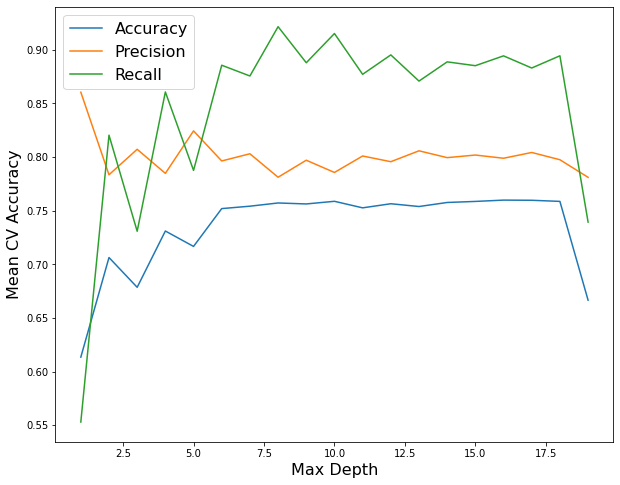

Precision: [0.8604759  0.78348795 0.8072352  0.78479461 0.82437944 0.79635172
 0.80305954 0.78117373 0.79704353 0.78563308 0.80098243 0.79566163
 0.80581493 0.79945144 0.8018724  0.79887775 0.80426316 0.79749995
 0.78108545]
[0.55293206 0.73081742 0.78756508 0.87558169 0.87713827 0.87082716
 0.88517565 0.88301532]
6
Our optimal cutoff at 15 gives is a recall of  0.885 with a precision of 0.802
Depth:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Precision:  [0.8604759  0.78348795 0.8072352  0.78479461 0.82437944 0.79635172
 0.80305954 0.78117373 0.79704353 0.78563308 0.80098243 0.79566163
 0.80581493 0.79945144 0.8018724  0.79887775 0.80426316 0.79749995
 0.78108545]
Recall:  [0.55293206 0.82039244 0.73081742 0.86068165 0.78756508 0.88561006
 0.87558169 0.9215478  0.8879248  0.91515911 0.87713827 0.89524274
 0.87082716 0.8887457  0.88517565 0.89435244 0.88301532 0.89440637
 0.7393584 ]


In [25]:
plt.figure(figsize=(10,8))

plt.plot(mn,np.mean(accs,axis=0),label="Accuracy")
plt.plot(mn,np.mean(precs,axis=0),label="Precision")
plt.plot(mn,np.mean(recs,axis=0),label="Recall")
#plt.plot(cutoffs,np.mean(f1s,axis=0),label="F1 Score")


plt.xlabel("Max Depth", fontsize=16)
plt.ylabel("Mean CV Score", fontsize=16)

plt.legend(fontsize=16)


plt.xlabel("Max Depth", fontsize=16)
plt.ylabel("Mean CV Accuracy", fontsize=16)
plt.savefig("LukePayer_kNN.jpg")
plt.show()

prec_guard = 0.8
prec = np.mean(precs,axis=0)
rec = np.mean(recs,axis=0)

prec2 = prec[prec>prec_guard]
rec2 = rec[prec>prec_guard]

#print(cutoffs[prec>prec_guard])
print("Precision:", prec)


#Find Highest recall with precision greater than guardrail value

print(rec2)
print(np.argmax(rec2))

l = np.argmax(rec2)
cot = mn[prec>prec_guard]

print("Our optimal cutoff at",np.round(cot[l],3),"gives is a recall of ",np.round(rec2[l],3),
      "with a precision of",np.round(prec2[l],3))


print("Depth: ",mn) 
print("Precision: ",prec)
print("Recall: ",rec)

In [ ]:
lpdf = lpdf.append(pd.DataFrame([['kNN',
                                 np.round(prec2[l],3),
                                 np.round(rec2[l],3)]],
                               columns=lpcl))